In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import data_setup
import engine
import utils
import helper_functions

from torch import nn
from torchvision import transforms
from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else 'cpu'

c:\Users\danie\GitHub\Food_Classifier\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = helper_functions.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
IMG_SIZE = 224
manual_transforms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
# create data loader
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transforms=manual_transforms, batch_size=BATCH_SIZE)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2390c986990>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

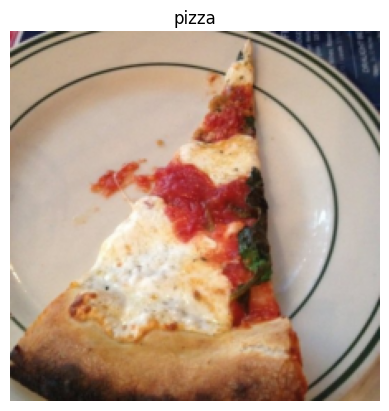

In [8]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

# Calculating the patch embedding input and output shapes

In [9]:
height = 224
width = 224
color_channels = 3
patch_size = 16 # best performing based on ViT paper

number_of_patches = int((height * width) / patch_size ** 2)
print(f"patch size (P={patch_size}): {number_of_patches}")

patch size (P=16): 196


In [10]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


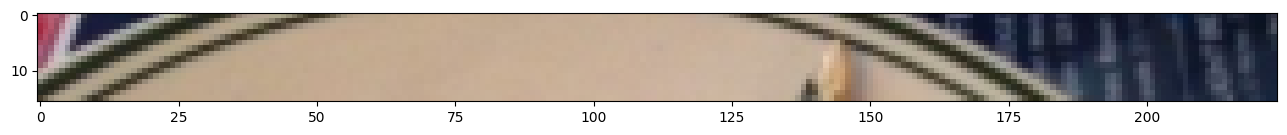

In [11]:
# top row
image_permuted = image.permute(1, 2, 0)
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


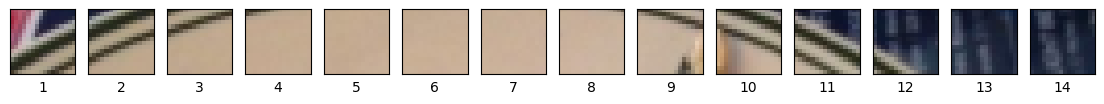

In [12]:
num_patches = IMG_SIZE/patch_size
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows = 1, ncols = IMG_SIZE//patch_size, figsize=(num_patches, number_of_patches), sharex=True, sharey=True)

for i, patch in enumerate(range(0, IMG_SIZE, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

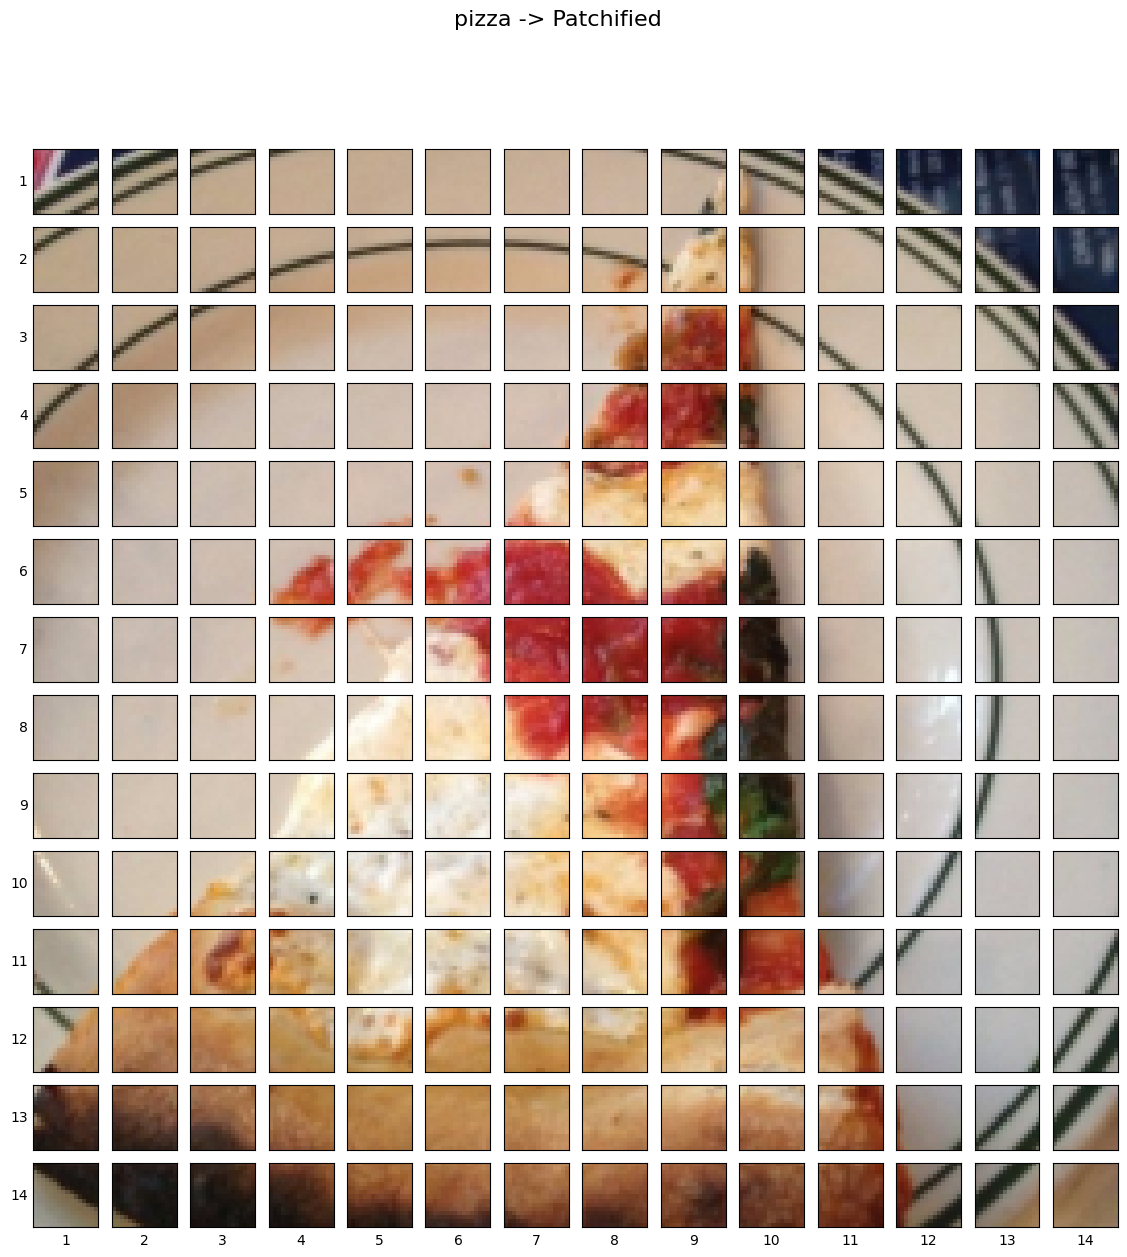

In [13]:


# Create a series of subplots
fig, axs = plt.subplots(nrows=IMG_SIZE // patch_size, # need int not float
                        ncols=IMG_SIZE // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, IMG_SIZE, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, IMG_SIZE, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [14]:
# Use CCN and kernel

from torch import nn
patch_size = 16

conv2d = nn.Conv2d(in_channels=3, out_channels = 768, kernel_size=patch_size, stride=patch_size, padding=0)

In [15]:
iamge_out_of_conv = conv2d(image.unsqueeze(0))
iamge_out_of_conv.shape #[batch_size, embedding_dim, feature_map_height, feature_map_width]

torch.Size([1, 768, 14, 14])

showing random convolution feature maps from indexes: [57, 492, 445, 198, 253]


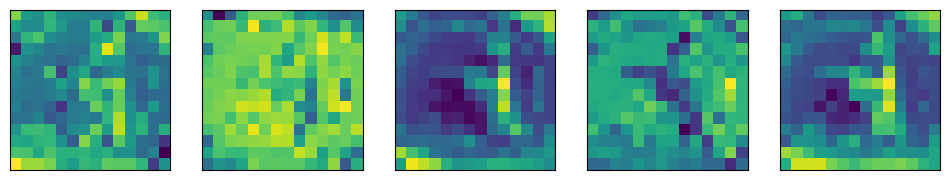

In [16]:
import random

# plot random convolutional feature maps
random_indexes = random.sample(range(0, 768), k = 5)
print(f"showing random convolution feature maps from indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = iamge_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = []);

In [17]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

In [18]:
# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


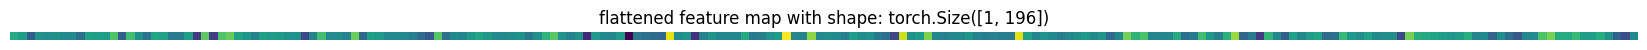

In [19]:
# get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened.permute(0, 2, 1)[:, :, 0]

plt.figure(figsize=(21, 21))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"flattened feature map with shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [20]:
# create patch embedding module
class PatchEmbeddings(nn.Module):
    """ 
    Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    
    def __init__(self, in_channels = 3, patch_size = 16, embedding_dim = 768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size, padding=0)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, "input image size must be divisible by patch size"
        
        #forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        return x_flattened.permute(0, 2 ,1)

In [21]:
helper_functions.set_seeds()

patchify = PatchEmbeddings(in_channels=3, patch_size=16, embedding_dim=768)

print(f"Input Image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output Image shape: {patch_embedded_image.shape}")

Input Image shape: torch.Size([1, 3, 224, 224])
Output Image shape: torch.Size([1, 196, 768])


In [22]:
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim), requires_grad=True)

print(class_token[:, :, 10])

print(f"class token shape: {class_token.shape}")

tensor([[1.]], grad_fn=<SelectBackward0>)
class token shape: torch.Size([1, 1, 768])


In [23]:
# prepend the class token embedding to the patch embeddings
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim = 1)
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [24]:
# create positional embeddings
number_of_patches = int((height * width) / patch_size**2)
embedding_dim = patch_embedded_image_with_class_embedding.shape[-1]
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dim), requires_grad=True)

position_embedding[:, :10, : 10]

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)

In [25]:
# add positional embeddings to patch and class embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

# Image to Embedding

In [26]:
helper_functions.set_seeds()

# get patch size
patch_size = 16

# print shape of original image and get dimensions
print(f"image shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# get image tensor and add batch dimension
x = image.unsqueeze(0)

# create patch embedding layer
patch_embedding_layer = PatchEmbeddings(in_channels=3, patch_size=patch_size, embedding_dim=768)

# pass iamge through embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch Embedding shape: {patch_embedding.shape}")

# create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim), requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# prepend the class tokens to the patch embeddings
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)
print(f"patch embedding with class token embedding shape: {patch_embedding_class_token.shape}")

# create positional embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dim), requires_grad=True)

# add postional embedding to patch embeddings with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"patch and position embedding shape: {patch_and_position_embedding.shape}")

image shape: torch.Size([3, 224, 224])
Patch Embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
patch embedding with class token embedding shape: torch.Size([1, 197, 768])
patch and position embedding shape: torch.Size([1, 197, 768])


# Multihead self attention block

In [27]:
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim = 768, num_heads = 12, attn_dropout = 0.0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query = x, key = x, value = x, need_weights = False)
        return attn_output

In [28]:
multi_head_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768, num_heads=12)

patched_image_through_msa_block = multi_head_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


# Add MLP block

In [29]:
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim=768, mlp_size=3072, dropout=0.0, device="cuda"):
        super().__init__()
        self.device = device  # Store device

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim).to(self.device)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        ).to(self.device)

    def forward(self, x):
        x = x.to(self.device)  # Ensure input is on the same device
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x


In [30]:
# create an instance of mlp block
mlp_block = MLPBlock(embedding_dim=768, mlp_size=3072, dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


# Create Transformer Encoder Block 

In [31]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12, mlp_size=3072, mlp_dropout=0.1, attn_dropout=0.0, device="cuda"):
        super().__init__()
        self.device = device  # Store device

        # Multi-head self-attention block
        self.msa_block = MultiHeadSelfAttentionBlock(
            embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout
        ).to(self.device)

        # MLP block
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout).to(self.device)

        # Layer Normalization (added before residual connections)
        self.layer_norm1 = nn.LayerNorm(embedding_dim).to(self.device)
        self.layer_norm2 = nn.LayerNorm(embedding_dim).to(self.device)

    def forward(self, x):
        x = x.to(self.device)  # Ensure input is on the same device

        # Apply LayerNorm before residual connections (standard in ViTs)
        x = x + self.msa_block(self.layer_norm1(x))
        x = x + self.mlp_block(self.layer_norm2(x))

        return x


In [32]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (layer_norm1)                          [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─LayerNorm (layer_norm2)                          [1, 197, 768]        [1, 197, 768]        1,536                True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)              

# creating ViT

In [33]:
class ViT(nn.Module):
    def __init__(self, img_size=224, in_channels=3, patch_size=16, num_transformer_layers=12, embedding_dim=768, mlp_size=3072,
                num_heads=12, attn_dropout=0.0, mlp_dropout=0.1, embedding_dropout=0.1, num_classes=1000, device='cuda'):
        super().__init__()
        
        self.device = device  # Store device

        assert img_size % patch_size == 0

        # Calculate number of patches
        self.num_patches = (img_size * img_size) // patch_size ** 2

        # Create learnable class embedding 
        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim, device=self.device), requires_grad=True)

        # Create learnable position embedding
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dim, device=self.device), requires_grad=True)

        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Create patch embedding layer
        self.patch_embedding = PatchEmbeddings(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim).to(self.device)

        # Create transformer encoder blocks
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(embedding_dim=embedding_dim, num_heads=num_heads, mlp_size=mlp_size, mlp_dropout=mlp_dropout).to(self.device)
            for _ in range(num_transformer_layers)]
        )

        # Create classifier head
        self.classifer = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        ).to(self.device)

    def forward(self, x):
        x = x.to(self.device)  # Ensure input is on the same device
        batch_size = x.shape[0]

        # Create class token embeddings for each batch
        class_tokens = self.class_embedding.expand(batch_size, -1, -1)

        # Create patch embedding
        x = self.patch_embedding(x)

        # Concatenate class tokens
        x = torch.cat((class_tokens, x), dim=1)

        # Add positional embeddings
        x = self.position_embedding + x

        # Run embedding dropout
        x = self.embedding_dropout(x)

        # Run through transformer encoder layers
        x = self.transformer_encoder(x)

        # Pass through classifier
        x = self.classifer(x[:, 0])  # Extract class token

        return x


In [34]:
helper_functions.set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.5976, -0.2785, -0.6109]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [35]:
optimizer = torch.optim.Adam(params=vit.parameters(), lr = 3e-3, betas = (0.9, 0.999), weight_decay=0.3)

loss_fn = torch.nn.CrossEntropyLoss()

helper_functions.set_seeds()

model = vit.to('cuda')  # Move model to GPU

results = engine.train(model=vit, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                       optimizer=optimizer, loss_fn=loss_fn, epochs=10, device= device)

 10%|█         | 1/10 [00:17<02:38, 17.59s/it]

Epoch: 1 | train_loss : 3.9699 | train_acc : 0.2773 | test_loss : 4.9829 | test_acc : 0.2604 | 


 20%|██        | 2/10 [00:36<02:24, 18.09s/it]

Epoch: 2 | train_loss : 2.5449 | train_acc : 0.4062 | test_loss : 1.9813 | test_acc : 0.2604 | 


 30%|███       | 3/10 [00:53<02:06, 18.00s/it]

Epoch: 3 | train_loss : 1.1923 | train_acc : 0.4844 | test_loss : 1.6049 | test_acc : 0.2604 | 


 40%|████      | 4/10 [01:11<01:47, 17.99s/it]

Epoch: 4 | train_loss : 1.2954 | train_acc : 0.2891 | test_loss : 1.5986 | test_acc : 0.1979 | 


 50%|█████     | 5/10 [01:29<01:29, 17.97s/it]

Epoch: 5 | train_loss : 1.1533 | train_acc : 0.4141 | test_loss : 1.4228 | test_acc : 0.2604 | 


 60%|██████    | 6/10 [01:47<01:12, 18.04s/it]

Epoch: 6 | train_loss : 1.1690 | train_acc : 0.4297 | test_loss : 1.4951 | test_acc : 0.1979 | 


 70%|███████   | 7/10 [02:05<00:53, 17.97s/it]

Epoch: 7 | train_loss : 1.3070 | train_acc : 0.2852 | test_loss : 1.3421 | test_acc : 0.2604 | 


 80%|████████  | 8/10 [02:23<00:35, 17.97s/it]

Epoch: 8 | train_loss : 1.1309 | train_acc : 0.2852 | test_loss : 1.2906 | test_acc : 0.2604 | 


 90%|█████████ | 9/10 [02:41<00:18, 18.03s/it]

Epoch: 9 | train_loss : 1.1488 | train_acc : 0.4297 | test_loss : 1.0285 | test_acc : 0.5417 | 


100%|██████████| 10/10 [02:59<00:00, 17.99s/it]

Epoch: 10 | train_loss : 1.2853 | train_acc : 0.2422 | test_loss : 1.4387 | test_acc : 0.2604 | 
